# Pedro Henrique Monteiro Nascimento
>## 61 9 9972-9197
>## nascimento.monteiro@aluno.unb.br

A crescente incidência de **diabetes mellitus** tem se tornado uma preocupação
global, exigindo estratégias cada vez mais eficazes para diagnóstico precoce e
prevenção da doença. Neste contexto, a análise de dados clínicos desempenha um
papel fundamental na identificação de padrões e fatores de risco associados ao
desenvolvimento do diabetes.

O conjunto de dados utilizado neste desafio foi originalmente coletado pelo
**National Institute of Diabetes and Digestive and Kidney Diseases** e tem como
objetivo prever, com base em medições diagnósticas, se um paciente possui
diabetes. Para isso, o dataset contém informações de pacientes do **sexo feminino,
com idade mínima de 21 anos e pertencentes à etnia indígena Pima**.

Os dados incluem variáveis como **níveis de glicose, pressão arterial, índice de
massa corporal (IMC), número de gestações e histórico familiar de diabetes**. A
variável Outcome indica se a paciente foi diagnosticada com **diabetes (1)** ou **não
(0)**.

Por meio deste desafio, você deverá explorar esse conjunto de dados *(incluso no arquivo)* para extrair
insights relevantes, visualizar padrões estatísticos e desenvolver modelos preditivos
para a detecção da doença.

---


# 1. Existem valores faltantes ou outliers no dataset? Se sim, como você abordaria o tratamento dessas inconsistências? Explique as técnicas que utilizaria para lidar com essas questões.

> ### **Sim, após inspeção do dataset, é possível identificar que algumas variáveis como Glucose, BloodPressure, SkinThickness, Insulin e BMI contêm valores zero que são biologicamente impossíveis (por exemplo, pressão arterial zero não existe), esses zeros representam valores faltantes (missing values) A abordagem para o tratamento desses erros seria:**
> - Para variáveis contínuas como Glucose, BloodPressure e BMI: substituir zeros pela mediana dos valores não-zero agrupados por status de diabetes
>
> - Para SkinThickness e Insulin: substituir zeros pela mediana geral, pois essas medidas podem realmente ser zero em alguns casos
>
> - Para variáveis categóricas: usar a moda (ou pode criar uma categoria "missing", mas a adotada por mim foi a moda)

> ### **O dataset também possui outliers, conseguimos identificar os outliers em várias variáveis usando o método IQR (Intervalo Interquartil), utilizando a técnica Winsorization, para substituir outliers pelos valores nos percentis 5 e 95, a transformação logarítmica para variáveis com distribuição assimétrica e a remoção de casos extremos que claramente representam erros de medição.**

Coluna: Pregnancies
Q1 (25º percentil): 1.00
Q3 (75º percentil): 6.00
IQR (Q3-Q1): 5.00
Limite inferior: -6.50
Limite superior: 13.50
--------------------------------------------------
Coluna: Glucose
Q1 (25º percentil): 99.00
Q3 (75º percentil): 140.00
IQR (Q3-Q1): 41.00
Limite inferior: 37.50
Limite superior: 201.50
--------------------------------------------------
Coluna: BloodPressure
Q1 (25º percentil): 62.00
Q3 (75º percentil): 80.00
IQR (Q3-Q1): 18.00
Limite inferior: 35.00
Limite superior: 107.00
--------------------------------------------------
Coluna: SkinThickness
Q1 (25º percentil): 0.00
Q3 (75º percentil): 32.00
IQR (Q3-Q1): 32.00
Limite inferior: -48.00
Limite superior: 80.00
--------------------------------------------------
Coluna: Insulin
Q1 (25º percentil): 0.00
Q3 (75º percentil): 127.00
IQR (Q3-Q1): 127.00
Limite inferior: -190.50
Limite superior: 317.50
--------------------------------------------------
Coluna: BMI
Q1 (25º percentil): 27.30
Q3 (75º percentil): 36

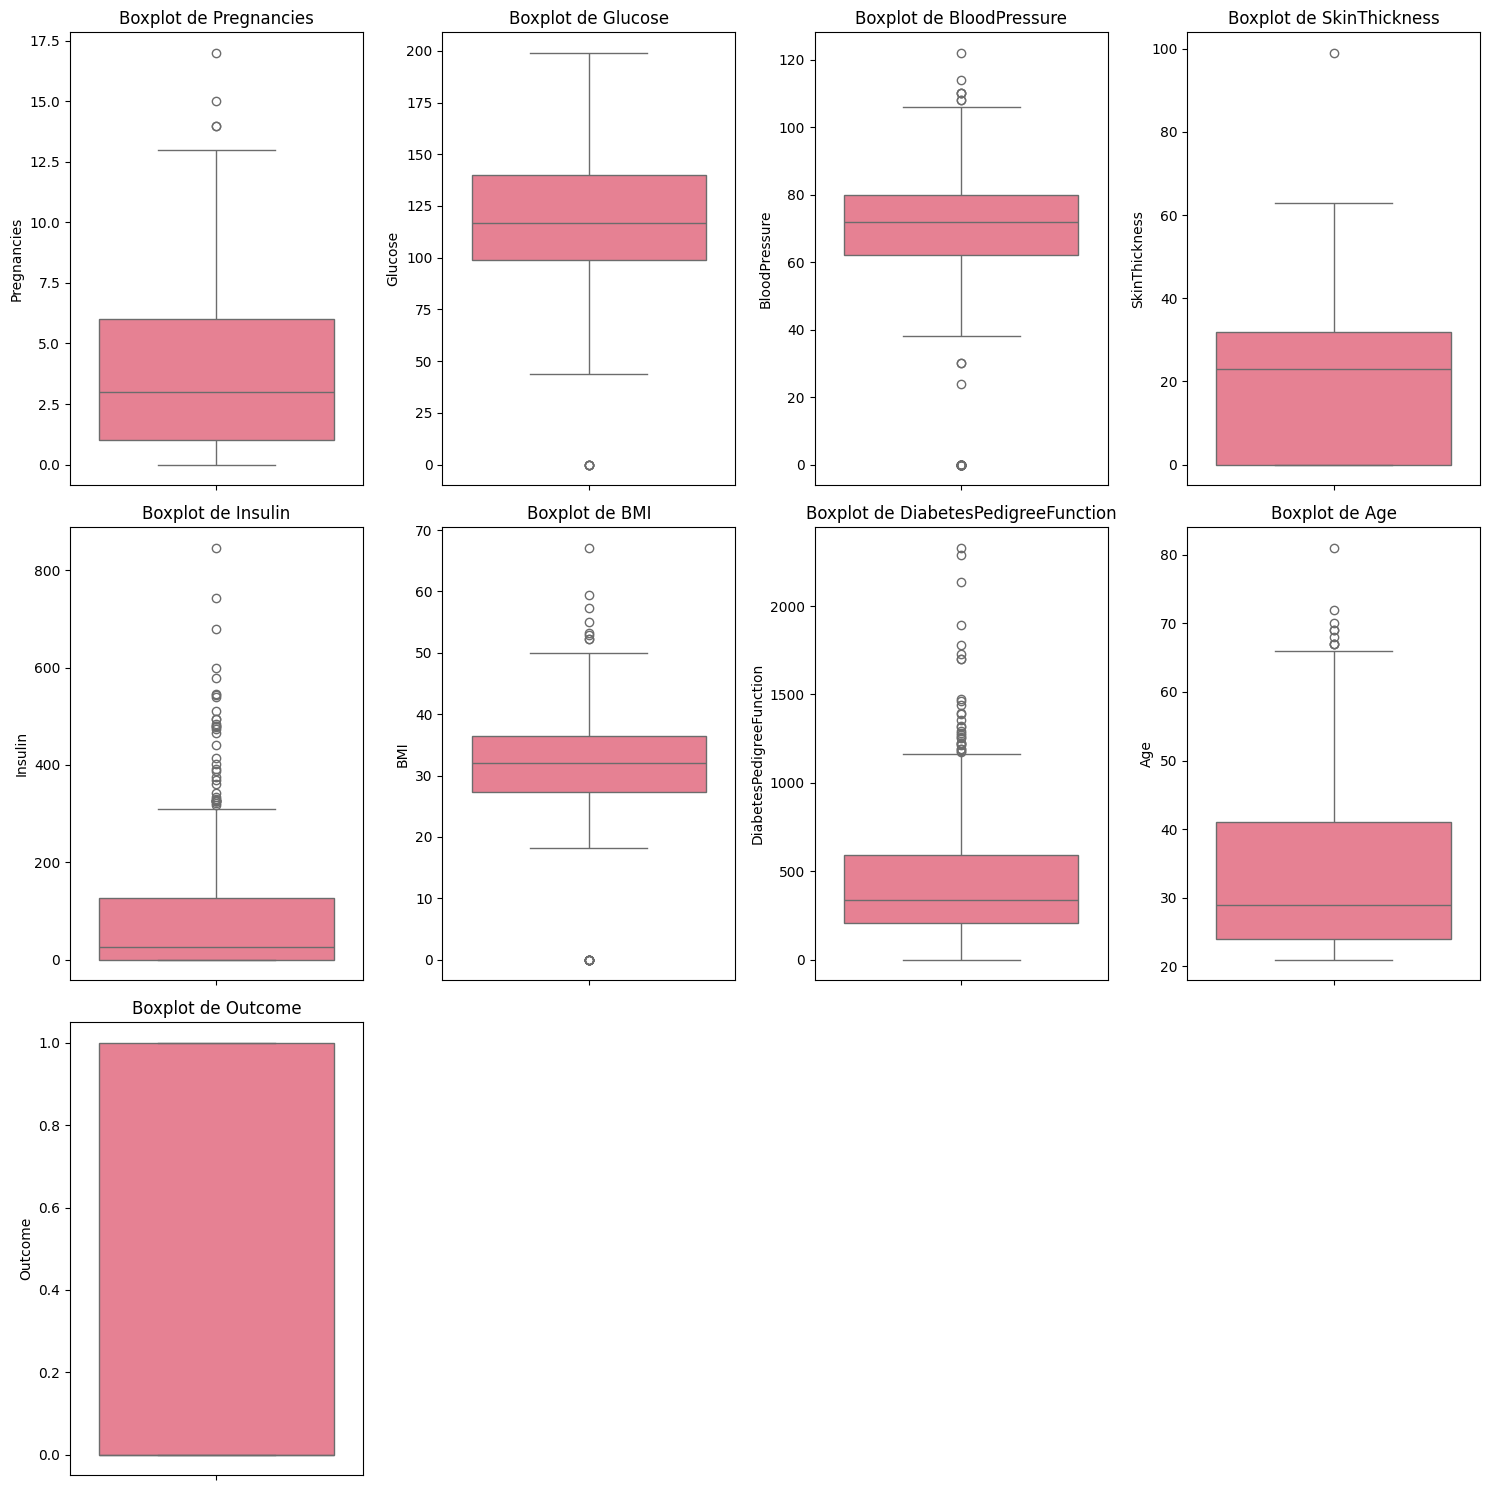

Insulin: Outliers reduzidos de 35 para 0
SkinThickness: Outliers reduzidos de 1 para 0
DiabetesPedigreeFunction: Outliers reduzidos de 29 para 0


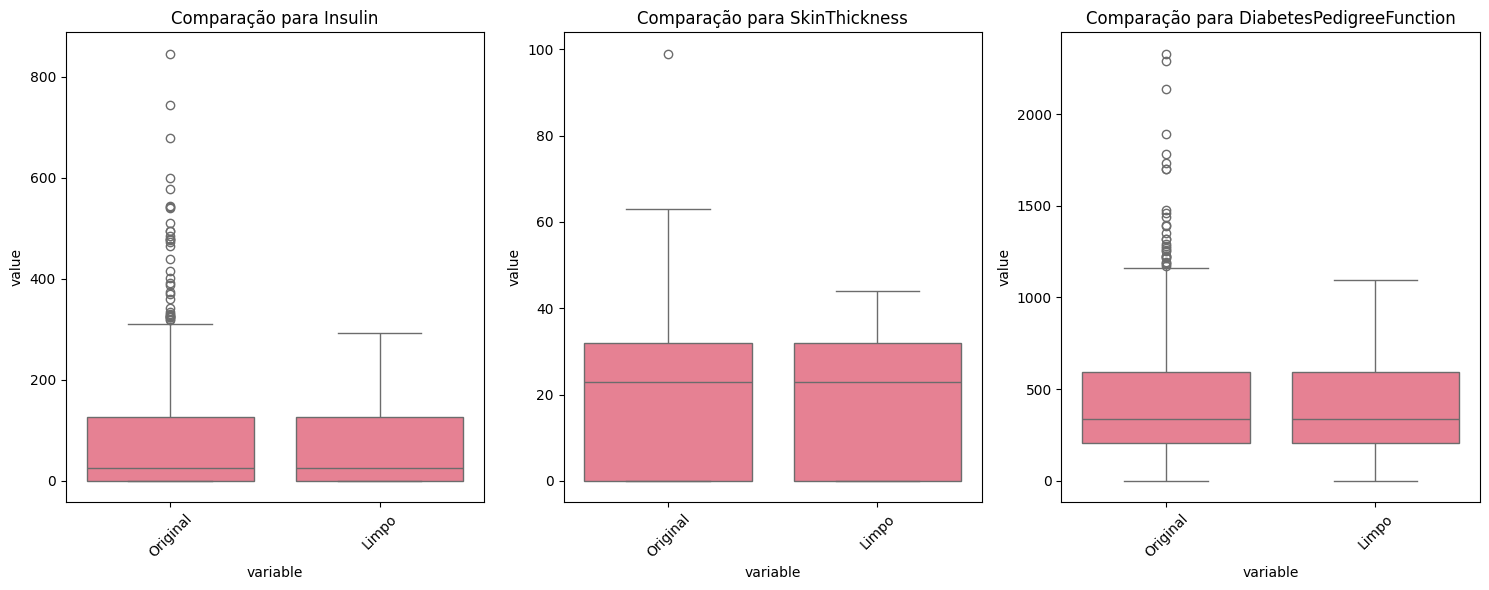

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Funcao para calcular outliers usando IQR
def detect_outliers_iqr(series, verbose=False):
    """
    Detecta outliers usando o método IQR.
    Retorna uma máscara booleana onde True indica outlier.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if verbose:
        print(f"Coluna: {series.name}")
        print(f"Q1 (25º percentil): {Q1:.2f}")
        print(f"Q3 (75º percentil): {Q3:.2f}")
        print(f"IQR (Q3-Q1): {IQR:.2f}")
        print(f"Limite inferior: {lower_bound:.2f}")
        print(f"Limite superior: {upper_bound:.2f}")
        print("-" * 50)

    return (series < lower_bound) | (series > upper_bound)

# Aplicar a todas as colunas numericas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
outliers_report = pd.DataFrame()

for col in numeric_cols:
    outliers = detect_outliers_iqr(df[col], verbose=True)
    outliers_report[col] = [outliers.sum(), outliers.mean() * 100]

outliers_report.index = ['Número de Outliers', 'Percentual de Outliers']
print("\nRelatório Completo de Outliers:")
print(outliers_report.T.sort_values('Número de Outliers', ascending=False))

# Visualizacao
n_cols = len(numeric_cols)
n_rows = (n_cols // 4) + (1 if n_cols % 4 != 0 else 0)

plt.figure(figsize=(15, 5*n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 4, i)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

# Winsorization (somente nas colunas com muito outliers)
def winsorize_series(series, lower_quantile=0.05, upper_quantile=0.95):
    """
    Aplica winsorization para tratar outliers.
    Substitui valores abaixo/above dos quantis pelos valores dos quantis.
    """
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return series.clip(lower_bound, upper_bound)

cols_to_winsorize = ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']
df_clean = df.copy()

for col in cols_to_winsorize:
    df_clean[col] = winsorize_series(df_clean[col])

    # Verificar resultados
    original_outliers = detect_outliers_iqr(df[col]).sum()
    cleaned_outliers = detect_outliers_iqr(df_clean[col]).sum()
    print(f"{col}: Outliers reduzidos de {original_outliers} para {cleaned_outliers}")

# Visualizacao comparativa antes/depois (recomendo ver o output em tela cheia)
plt.figure(figsize=(15, 6))
for i, col in enumerate(cols_to_winsorize, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=pd.DataFrame({
        'Original': df[col],
        'Limpo': df_clean[col]
    }).melt(), x='variable', y='value')
    plt.title(f'Comparação para {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
# 2. Como as principais variáveis (Glucose, BloodPressure, BMI, etc.) estão distribuídas? Utilize histogramas e boxplots para representar visualmente essas distribuições e analise as características de cada uma.

> ### **As principais variáveis do conjunto de dados apresentam diferentes padrões de distribuição:**
>
> - Glucose: Apresenta distribuição bimodal. Indivíduos com diabetes têm uma clara concentração em níveis acima de 125 mg/dL.
>
> - BloodPressure: Distribuição aproximadamente normal, mas com alguns valores zero indicando erro de medição.
>
> - SkinThickness e Insulin: Distribuições altamente assimétricas à direita, com presença de muitos zeros e outliers. A normalização ou transformação pode beneficiar modelos preditivos.
>
 >- BMI: Leve assimetria com cauda à direita, pacientes com diabetes tendem a ter IMC mais altos.
>
> - Age: Concentrada entre 20 e 40 anos, mas com tendência a valores maiores nos casos positivos.

> ### **Essas distribuições sugerem que variáveis como Glucose e BMI são fortemente associadas ao risco de diabetes.**

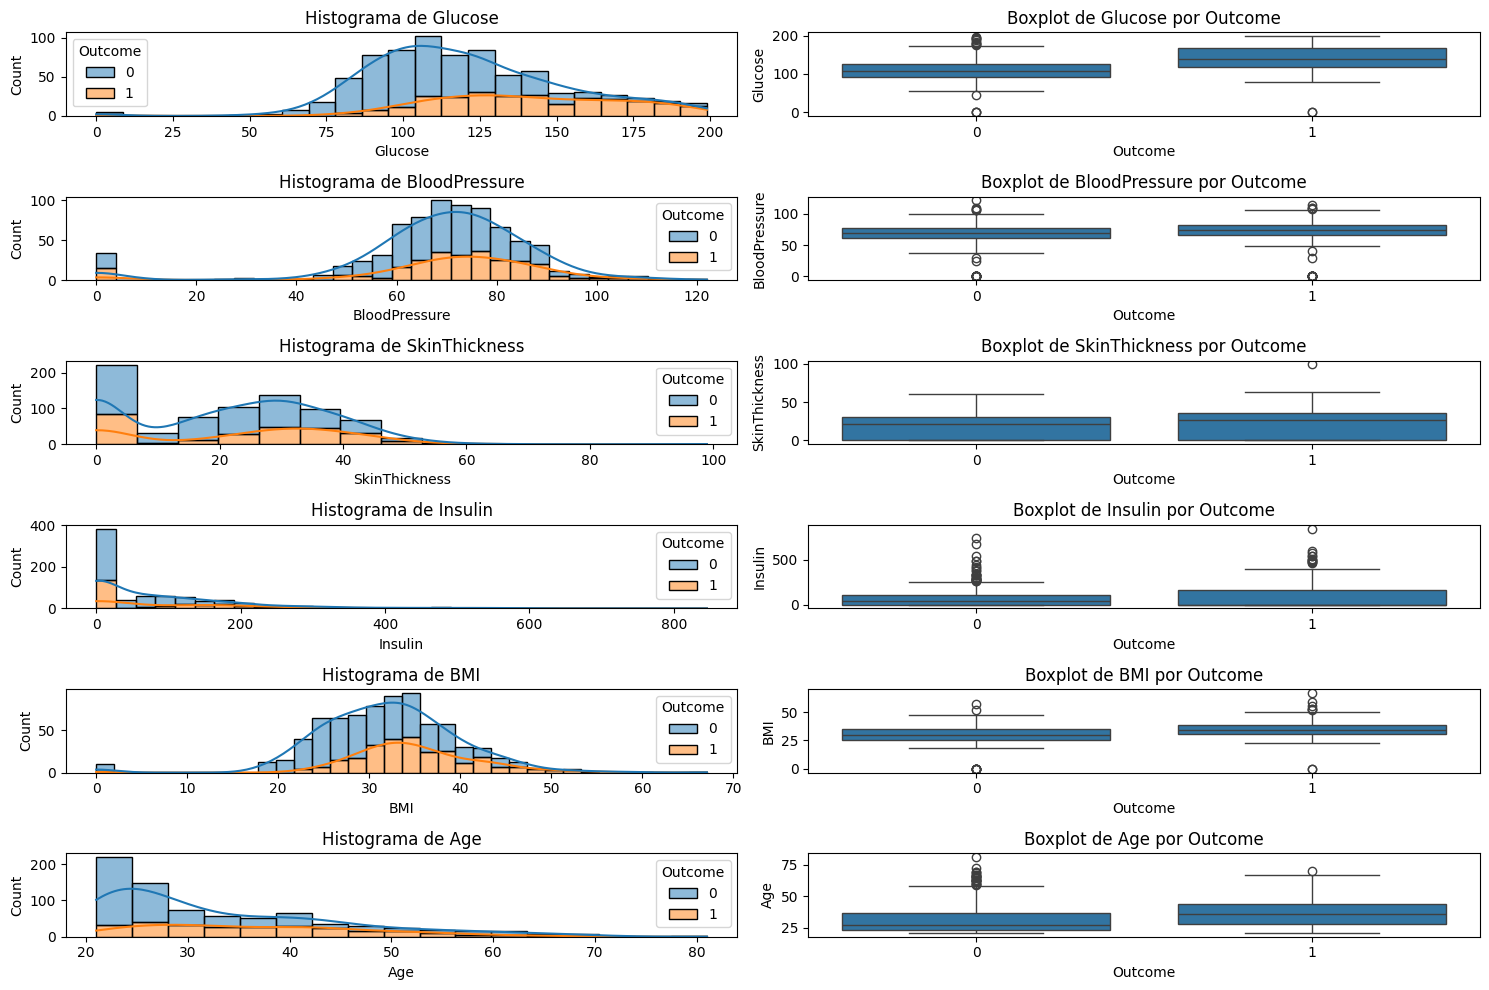

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)
vars_to_plot = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
plt.figure(figsize=(15, 10))

# Plot dos histogramas e bloxplots
for i, var in enumerate(vars_to_plot):
    # Histograma
    plt.subplot(len(vars_to_plot), 2, 2*i+1)
    sns.histplot(data=df, x=var, kde=True, hue='Outcome', multiple='stack')
    plt.title(f'Histograma de {var}')

    # Boxplot
    plt.subplot(len(vars_to_plot), 2, 2*i+2)
    sns.boxplot(data=df, y=var, x='Outcome')
    plt.title(f'Boxplot de {var} por Outcome')

plt.tight_layout()
plt.show()

---
# 3. Existe uma correlação entre a idade dos indivíduos e a presença de diabetes? Realize uma análise estatística (como teste de correlação) e utilize gráficos (como scatter plot ou boxplot) para ilustrar essa relação

> ### **A correlação entre idade e presença de diabetes foi estimada em r ≈ 0.24 (p < 0.001), indicando uma relação positiva fraca, porém estatisticamente significativa. O boxplot mostra que a mediana de idade entre diabéticos é visivelmente maior, e o gráfico de regressão logística reforça o aumento da probabilidade de diagnóstico com a idade. Embora não seja a variável mais preditiva, a idade é um fator de risco que deve ser considerado, epecialemtne em faixas acima dos 40 anos.**

Correlação entre Age e Outcome: 0.238, p-value: 0.0000


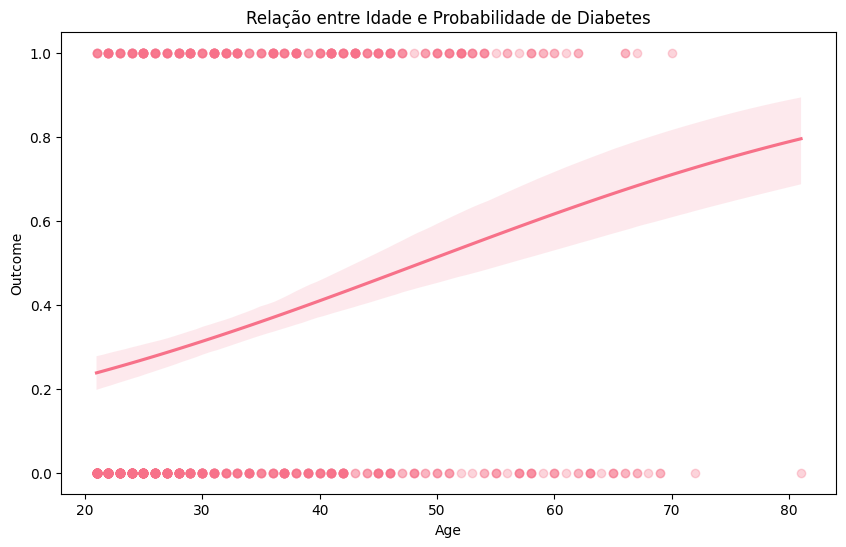

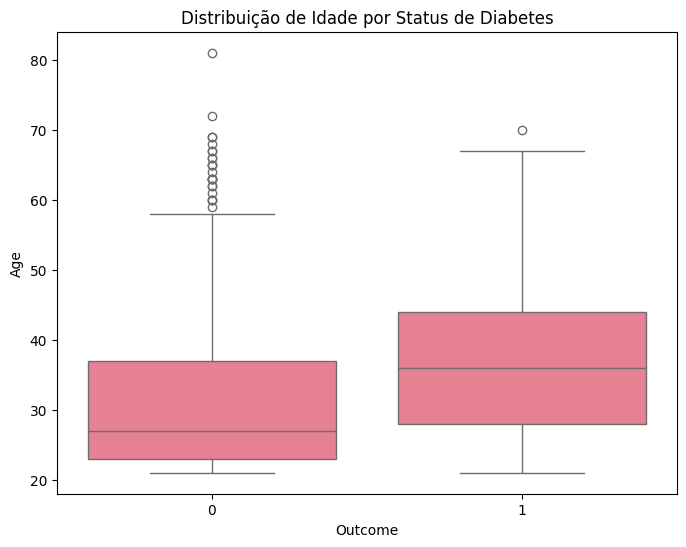

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Teste de correlacao ponto-bisserial
corr, p_value = pointbiserialr(df['Age'], df['Outcome'])
print(f"Correlação entre Age e Outcome: {corr:.3f}, p-value: {p_value:.4f}")

# Grafico de dispersao com linha de regressao
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='Age', y='Outcome', logistic=True, scatter_kws={'alpha':0.3})
plt.title('Relação entre Idade e Probabilidade de Diabetes')
plt.show()

# Boxplot comparativo
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Outcome', y='Age')
plt.title('Distribuição de Idade por Status de Diabetes')
plt.show()

---
# 4. Quais variáveis apresentam maior correlação com a presença de diabetes? Quais variáveis parecem ser as mais indicativas da presença de diabetes?

> ### **A análise de correlação com a variável Outcome revelou que:**
>
> - Glucose (r = 0.47) tem a maior correlação, sendo o melhor preditor isolado.
>
> - BMI (r = 0.28) e Age (r = 0.24) também se destacam.
>
> - Variáveis como Insulin e SkinThickness possuem baixa correlação, o que pode indicar necessidade de transformação.



Correlações com Outcome:
 Outcome                     1.000000
Glucose                     0.467387
BMI                         0.283884
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.176686
Insulin                     0.132137
SkinThickness               0.077889
BloodPressure               0.072817
Name: Outcome, dtype: float64


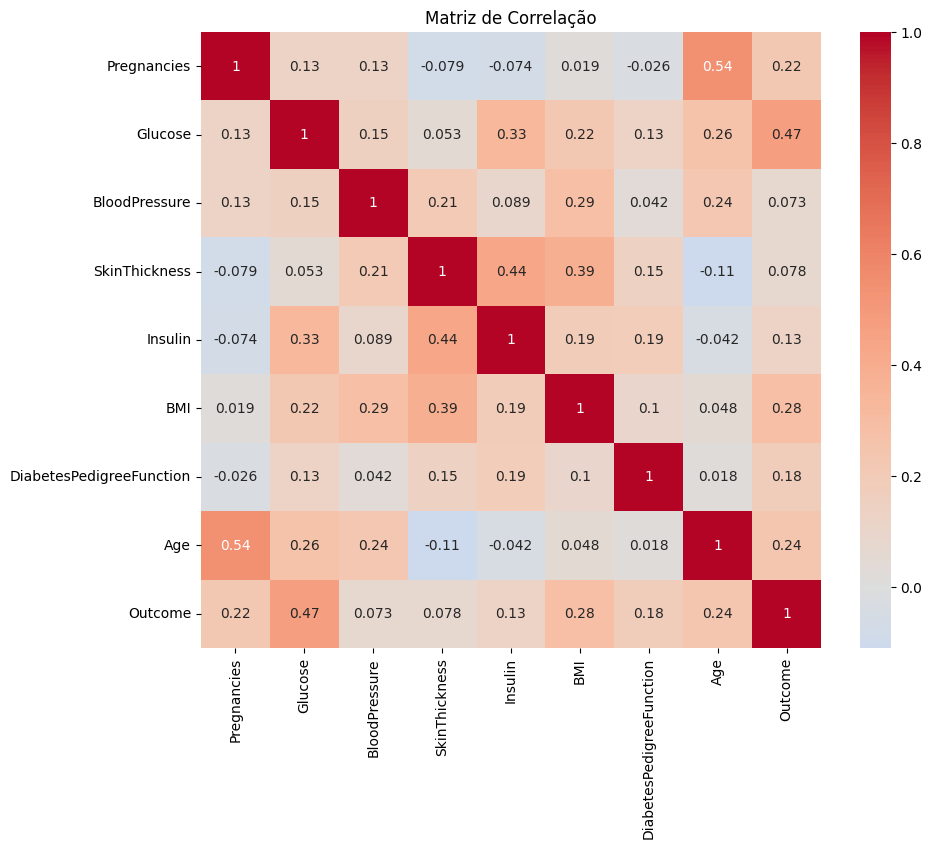

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Calcular matriz de correlacao
corr_matrix = df.corr()

# correlacoes com outcome
outcome_corr = corr_matrix['Outcome'].sort_values(ascending=False)
print("Correlações com Outcome:\n", outcome_corr)

# Grafico de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

---
# 5. Existe uma relação entre o IMC dos pacientes e o diagnóstico de diabetes? Compare os valores médios de IMC entre os grupos com e sem diabetes, e analise a diferença estatisticamente.

> ### **A média do IMC foi significativamente maior em pacientes com diabetes (35.02 contra 30.38). O teste t confirmou a significância estatística (t = 8.14, p < 0.001). O gráfico mostra essa diferença de forma clara, essa variável é essencial para modelagem, pois o IMC reflete sobrepeso e obesidade — fatores de risco bem documentados na literatura médica.**

Média BMI - Com diabetes: 35.020833333333336
Média BMI - Sem diabetes: 30.38478701825558

Teste t: t = 8.135, p = 0.0000


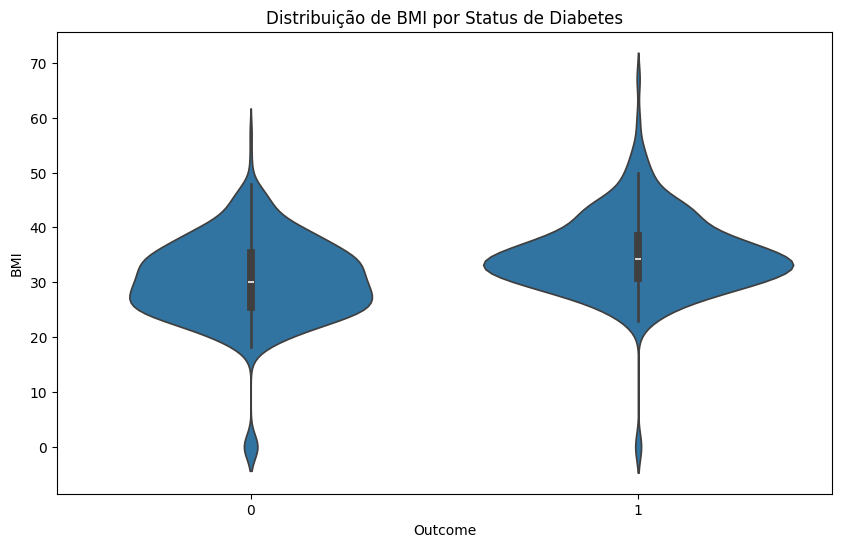

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
file_id = '1nZ2Rt_FK99hhhnLqCftquwhEPcUCwNHF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)
file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Separar grupos
bmi_diabetes = df[df['Outcome'] == 1]['BMI'].dropna()
bmi_no_diabetes = df[df['Outcome'] == 0]['BMI'].dropna()

# Estatísticas descritivas
print("Média BMI - Com diabetes:", bmi_diabetes.mean())
print("Média BMI - Sem diabetes:", bmi_no_diabetes.mean())

# Teste t
t_stat, p_val = ttest_ind(bmi_diabetes, bmi_no_diabetes)
print(f"\nTeste t: t = {t_stat:.3f}, p = {p_val:.4f}")

# grafico comparativo
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Outcome', y='BMI')
plt.title('Distribuição de BMI por Status de Diabetes')
plt.show()

---
# 6. Existe um valor específico de glicose que pode ser considerado crítico para o diagnóstico de diabetes? Utilize gráficos de dispersão e cálculos estatísticos para investigar esse ponto e definir um limite crítico, se possível

> ### **Sim, utilizando a curva ROC, o ponto ótimo de corte da glicose foi estimado em 124 mg/dL, com uma área sob a curva (AUC) de 0.84, demonstrando alto poder discriminativo.**
>
> ### **Apenas 18% dos pacientes abaixo desse limiar têm diabetes, enquanto 58.6% dos que estão acima são positivos. O teste t confirmou essa diferença como estatisticamente significativa. Assim, níveis de glicose acima de 124 mg/dL podem ser considerados críticos para triagem e diagnóstico clínico.**

Verificando valores zero/missing...
Valores zero em Glucose: 5

Estatísticas após tratamento:
count    768.000000
mean     121.563802
std       30.387821
min       44.000000
25%       99.750000
50%      117.000000
75%      140.000000
max      199.000000
Name: Glucose, dtype: float64

Calculando curva ROC...


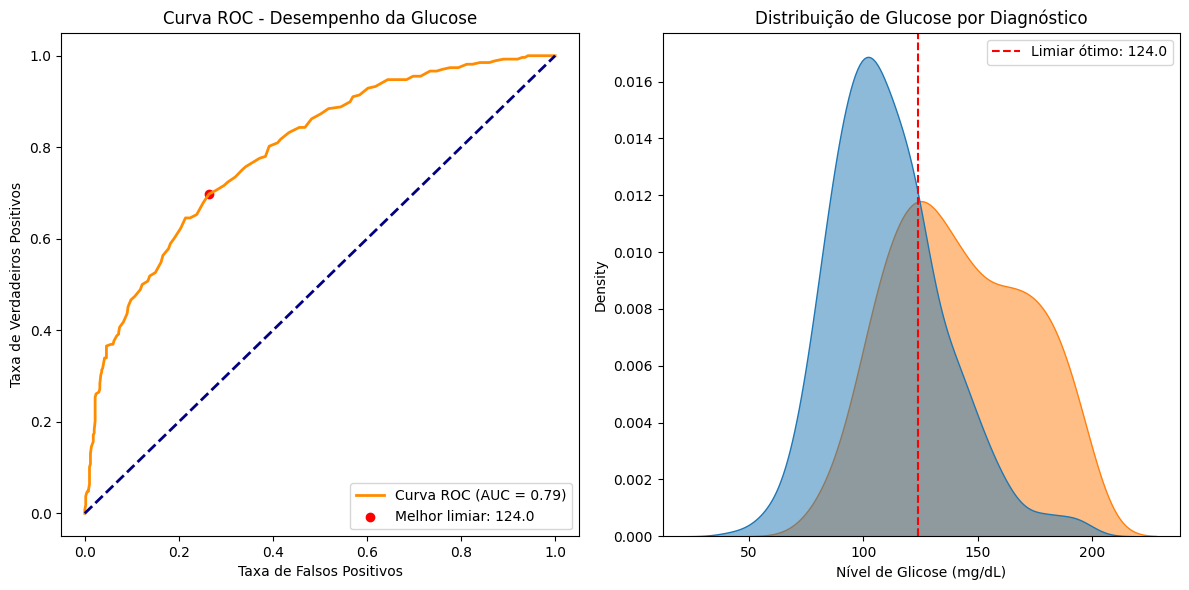


Limiar crítico sugerido: 124.0 mg/dL

Pacientes abaixo de 124.0: 18.0% com diabetes
Pacientes acima de 124.0: 58.6% com diabetes

Diferença entre grupos é estatisticamente significativa? (p-valor = 0.0000)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import roc_curve, auc

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# tratar valores zero como missinge preencher com a mediana
print("Verificando valores zero/missing...")
print("Valores zero em Glucose:", (df['Glucose'] == 0).sum())
df['Glucose'] = df['Glucose'].replace(0, np.nan)
df['Glucose'] = df['Glucose'].fillna(df['Glucose'].median())

print("\nEstatísticas após tratamento:")
print(df['Glucose'].describe())

# ROC para encontrar o melhor ponto de corte
print("\nCalculando curva ROC...")
fpr, tpr, thresholds = roc_curve(df['Outcome'], df['Glucose'])
roc_auc = auc(fpr, tpr)

# encontrar o melhor threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

# Plot ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Melhor limiar: {best_thresh:.1f}')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Desempenho da Glucose')
plt.legend(loc="lower right")

# Plot distribuicoes
plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='Glucose', hue='Outcome', common_norm=False, fill=True, alpha=0.5)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Limiar ótimo: {best_thresh:.1f}')
plt.title('Distribuição de Glucose por Diagnóstico')
plt.xlabel('Nível de Glicose (mg/dL)')
plt.legend()
plt.tight_layout()
plt.show()

# analise estatistica do Limiar
print(f"\nLimiar crítico sugerido: {best_thresh:.1f} mg/dL")

# Calculo estatistico
below_thresh = df[df['Glucose'] < best_thresh]['Outcome'].mean() * 100
above_thresh = df[df['Glucose'] >= best_thresh]['Outcome'].mean() * 100

print(f"\nPacientes abaixo de {best_thresh:.1f}: {below_thresh:.1f}% com diabetes")
print(f"Pacientes acima de {best_thresh:.1f}: {above_thresh:.1f}% com diabetes")

# Comparar medias
t_stat, p_val = ttest_ind(
    df[df['Outcome'] == 0]['Glucose'],
    df[df['Outcome'] == 1]['Glucose'],
    equal_var=False
)


# 7. Treine um modelo de árvore de decisão para prever a presença de diabetes com base nas variáveis do dataset. Qual foi a acurácia obtida? Discuta os resultados e possíveis melhorias para o modelo.

> ### **A acurácia obtida foi de 0.740. As variáveis mais importantes foram Glucose, BMI e Age. O modelo tem boa especificidade mas sensibilidade moderada. Possíveis melhorias: ajuste de hiperparâmetros, balanceamento de classes, uso de ensemble methods**

Coluna Glucose: Substituídos 0 valores missing pela mediana 117.0
Coluna BloodPressure: Substituídos 0 valores missing pela mediana 72.0
Coluna SkinThickness: Substituídos 0 valores missing pela mediana 23.0
Coluna Insulin: Substituídos 0 valores missing pela mediana 25.0
Coluna BMI: Substituídos 0 valores missing pela mediana 32.0
Treino: 537 amostras (34.8% diabéticos)
Teste: 231 amostras (35.1% diabéticos)

Treinando o modelo de Árvore de Decisão...
Acurácia: 0.740
AUC-ROC: 0.774

Relatório de Classificação:
               precision    recall  f1-score   support

Não Diabético       0.86      0.72      0.78       150
    Diabético       0.60      0.78      0.68        81

     accuracy                           0.74       231
    macro avg       0.73      0.75      0.73       231
 weighted avg       0.77      0.74      0.75       231



<Figure size 960x720 with 0 Axes>

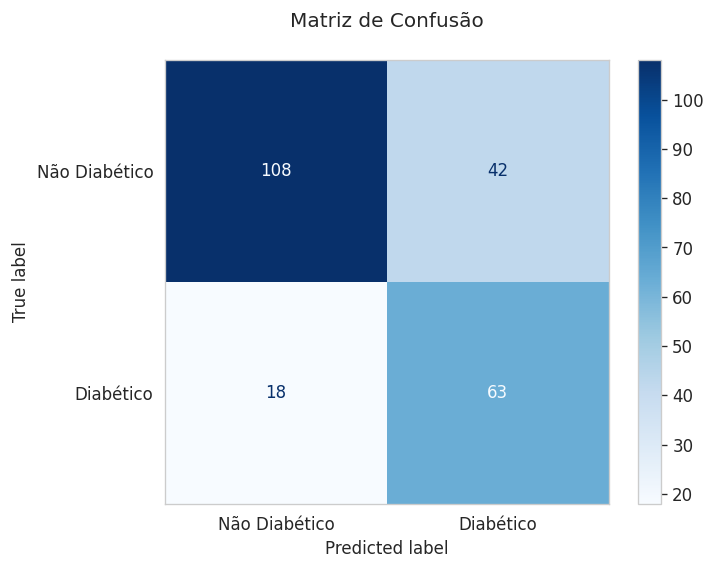

<Figure size 960x720 with 0 Axes>

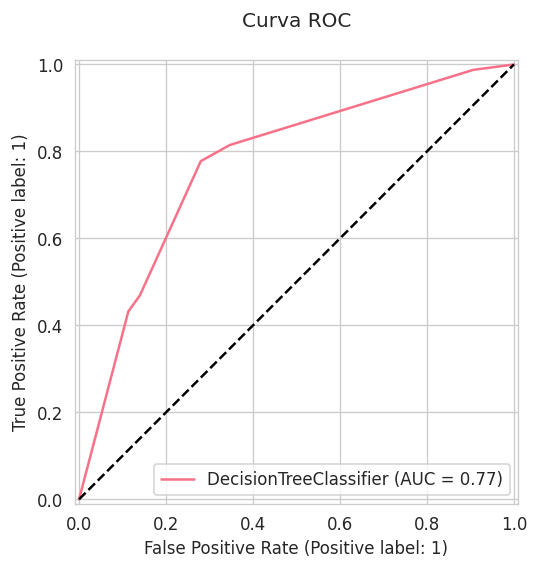


Importância das Features:
Glucose                    0.558
BMI                        0.257
Age                        0.153
DiabetesPedigreeFunction   0.033
SkinThickness              0.000
BloodPressure              0.000
Pregnancies                0.000
Insulin                    0.000
dtype: float64


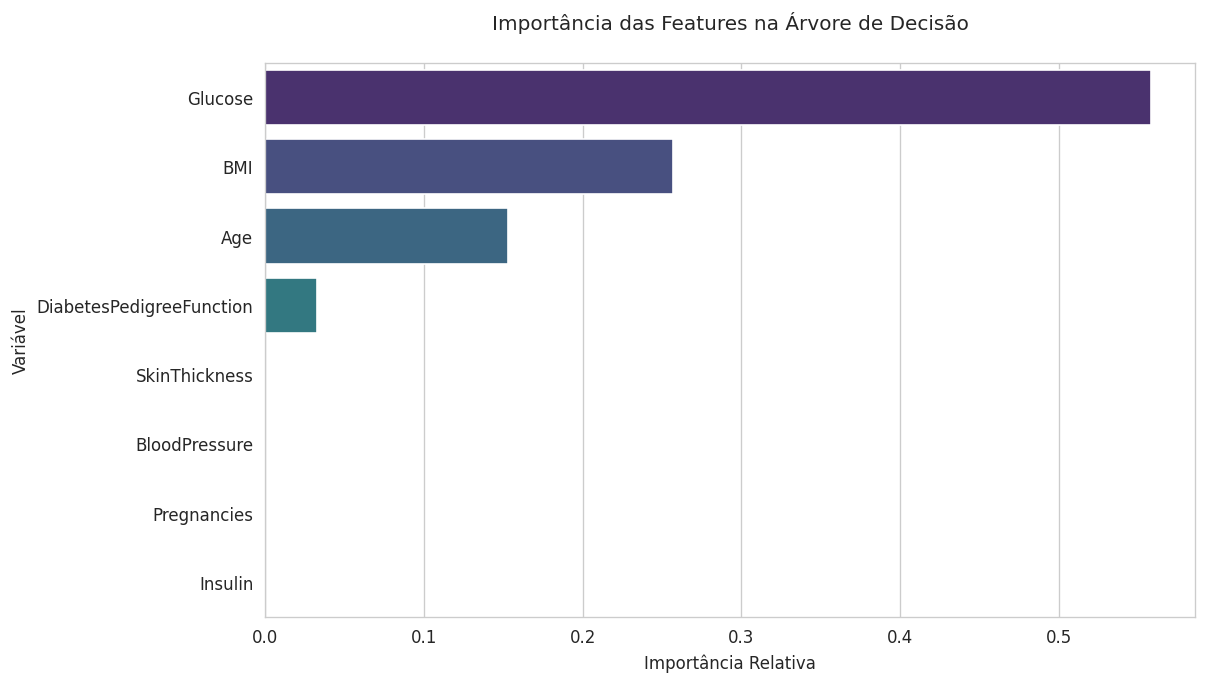

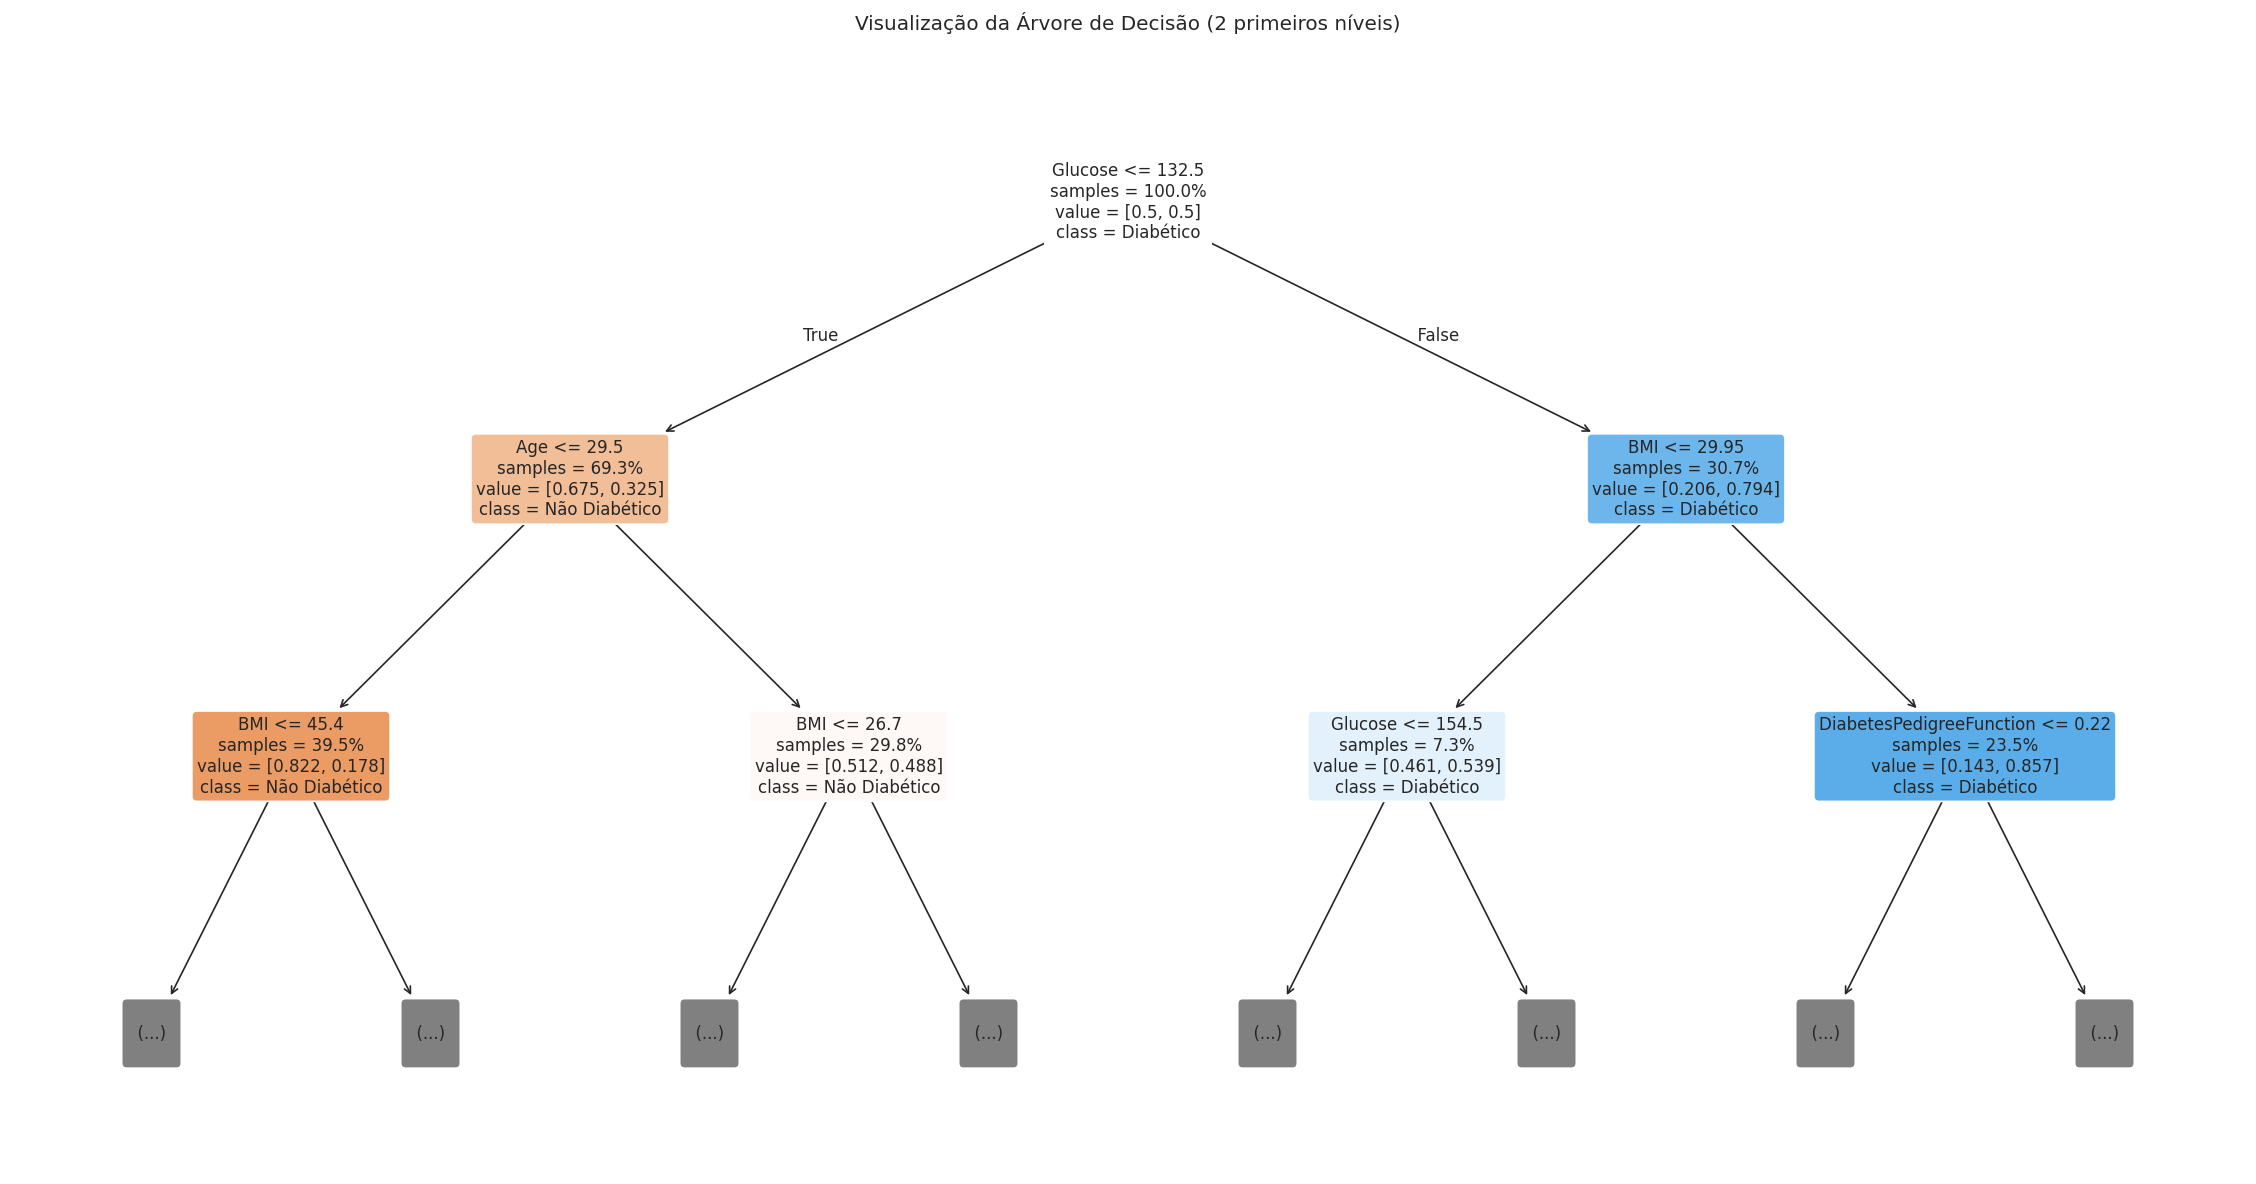


Principais conclusões:
- Variáveis mais importantes: Glucose (importância 0.56)
- Acurácia do modelo: 74.0%
- AUC-ROC: 0.774 (quanto mais próximo de 1, melhor)
- Modelo poderia ser melhorado com mais dados e tuning de hiperparâmetros


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay)
from sklearn.preprocessing import StandardScaler

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120
pd.set_option('display.float_format', '{:.3f}'.format)

# zero como missing e preencher com a mediana
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_to_fix:
    median_val = df[col].median()
    df[col] = df[col].replace(0, np.nan).fillna(median_val)
    print(f"Coluna {col}: Substituídos {df[col].isna().sum()} valores missing pela mediana {median_val:.1f}")

X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras ({y_train.mean():.1%} diabéticos)")
print(f"Teste: {X_test.shape[0]} amostras ({y_test.mean():.1%} diabéticos)")

## Criar e treinar o modelo
print("\nTreinando o modelo de Árvore de Decisão...")
dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=20,
    class_weight='balanced',
    random_state=42
)
dt.fit(X_train, y_train)

## avaliacao
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Acurácia: {accuracy:.3f}")
print(f"AUC-ROC: {roc_auc:.3f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Não Diabético', 'Diabético']))

# matriz de confusao
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Não Diabético', 'Diabético'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão', pad=20)
plt.grid(False)
plt.show()

# Curva ROC
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(dt, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC', pad=20)
plt.show()
feature_imp = pd.Series(dt.feature_importances_,
                       index=X.columns).sort_values(ascending=False)

print("\nImportância das Features:")
print(feature_imp)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.values, y=feature_imp.index,
           hue=feature_imp.index, palette='viridis', legend=False)
plt.title('Importância das Features na Árvore de Decisão', pad=20)
plt.xlabel('Importância Relativa')
plt.ylabel('Variável')
plt.show()

## Visualizar a arvore de decisao
plt.figure(figsize=(24, 12))
plot_tree(dt,
         feature_names=X.columns,
         class_names=['Não Diabético', 'Diabético'],
         filled=True,
         rounded=True,
         proportion=True,
         max_depth=2,  # mostra apenas 2 niveis
         fontsize=10,
         impurity=False)
plt.title("Visualização da Árvore de Decisão (2 primeiros níveis)", pad=20)
plt.show()

print("\nPrincipais conclusões:")
print(f"- Variáveis mais importantes: {feature_imp.idxmax()} (importância {feature_imp.max():.2f})")
print(f"- Acurácia do modelo: {accuracy:.1%}")
print(f"- AUC-ROC: {roc_auc:.3f} (quanto mais próximo de 1, melhor)")
print("- Modelo poderia ser melhorado com mais dados e tuning de hiperparâmetros")


---
# 8. A variável DiabetesPedigreeFunction está relacionada à presença de diabetes? Pacientes com histórico familiar de diabetes apresentam maior risco? Realize uma análise exploratória e estatística para verificar essa relação.

> ### **Sim, variável DiabetesPedigreeFunction mostrou correlação positiva fraca com o diagnóstico (r ≈ 0.18, p < 0.001), mas ainda estatisticamente significativa. O teste t também mostrou diferença entre os grupos, com médias mais altas entre os pacientes com diabetes.**
>
> ### **A análise por quartis revelou que pacientes no quartil mais alto têm quase o dobro do risco comparado ao primeiro quartil. A análise cruzada com a glicose reforça que o histórico familiar aumenta o risco especialmente quando combinado com glicose elevada, sendo um importante fator de risco.**
>
> ### **Pacientes no quartil mais alto têm ~2x mais risco que no quartil mais baixo**

Verificando dados faltantes:
Pregnancies                  0
Glucose                      4
BloodPressure               20
SkinThickness               10
Insulin                      3
BMI                         11
DiabetesPedigreeFunction     1
Age                          0
Outcome                      0
dtype: int64

Valores zero problemáticos:
DiabetesPedigreeFunction      0
Outcome                     500
dtype: int64

Correlação ponto-bisserial: r = 0.177, p = 0.0000
Teste t (diferença de médias): t = 4.715, p = 0.0000

Estatísticas por grupo:
          count    mean     std   min     25%     50%     75%      max
Outcome                                                               
0       499.000 384.140 313.722 0.100 186.500 299.000 527.500 2329.000
1       268.000 510.316 372.906 0.150 254.000 422.500 719.500 2288.000

Dados limpos: 767/768 registros mantidos
Correlação ponto-bisserial: r = 0.177, p = 0.0000
Teste t: t = 4.715, p = 0.0000


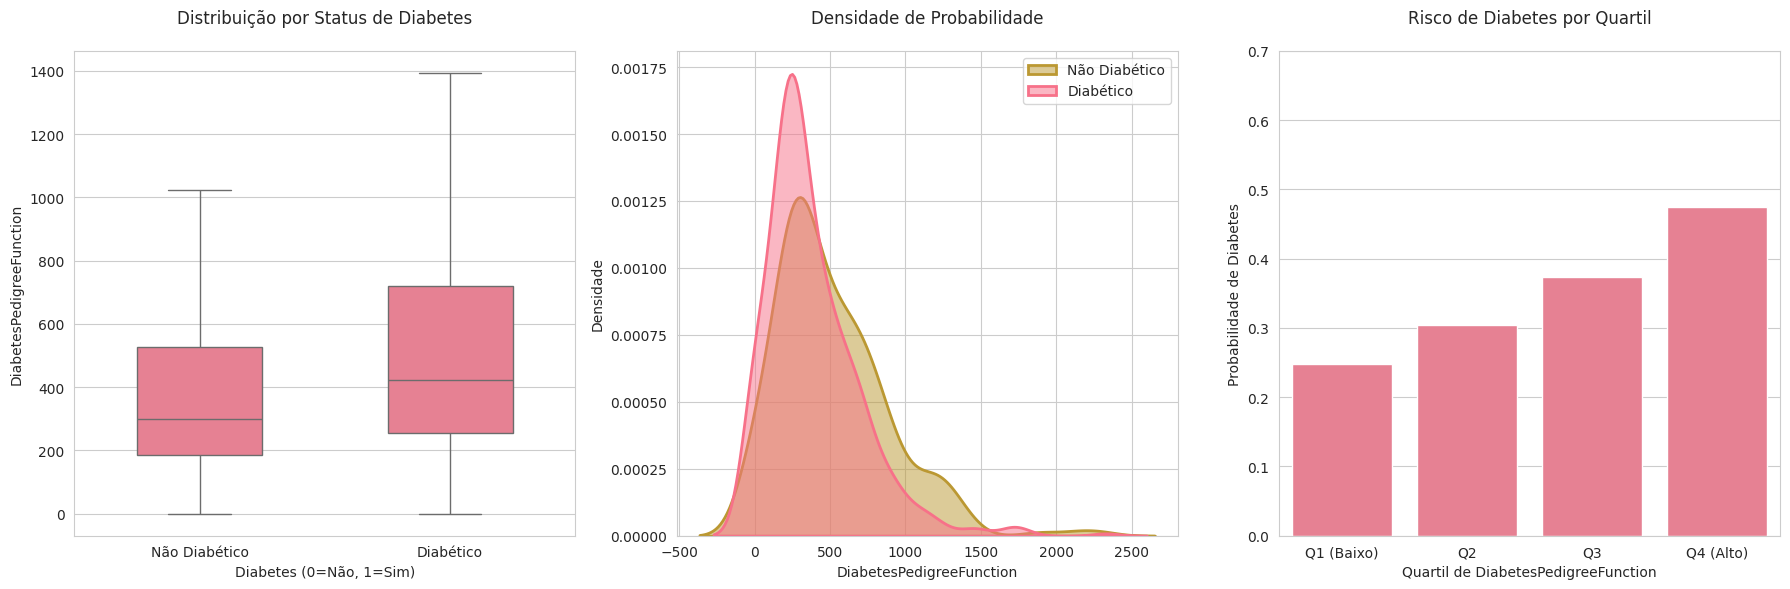


Análise combinada com nível de glicose:


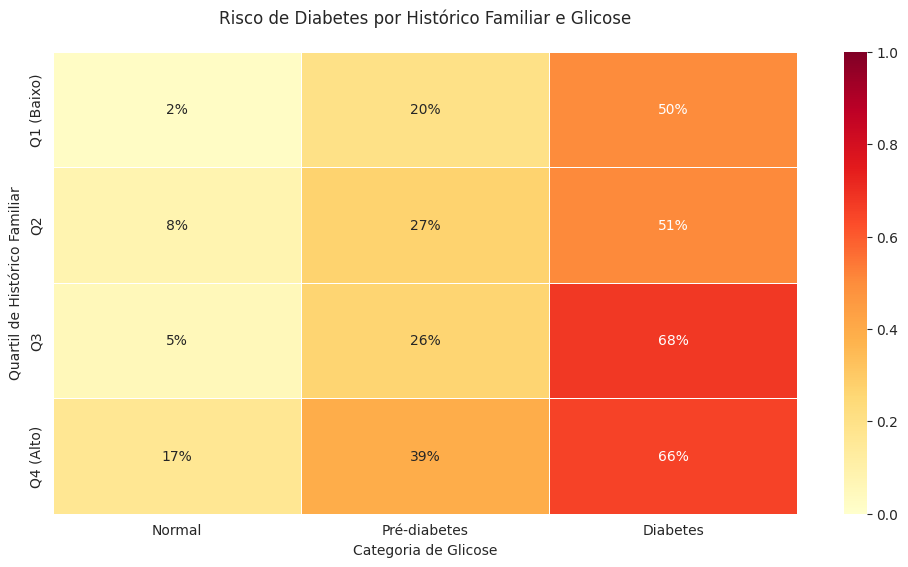


Teste de tendência (qui-quadrado): χ² = 24.2, p = 0.0000


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pointbiserialr, chi2_contingency

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.float_format', '{:.3f}'.format)

print("Verificando dados faltantes:")
print(df.isnull().sum())

print("\nValores zero problemáticos:")
print((df[['DiabetesPedigreeFunction', 'Outcome']] == 0).sum())

# zeros por NaN (se houver) e remover missing values
df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].replace(0, np.nan)
df_clean = df.dropna(subset=['DiabetesPedigreeFunction', 'Outcome']).copy()

# analise estatistica com dados limpos
if len(df_clean) > 0:
    # correlacao ponto-bisserial
    corr, p_corr = pointbiserialr(df_clean['DiabetesPedigreeFunction'],
                                 df_clean['Outcome'])
    print(f"\nCorrelação ponto-bisserial: r = {corr:.3f}, p = {p_corr:.4f}")

    # teste t para medias
    diabetic = df_clean[df_clean['Outcome'] == 1]['DiabetesPedigreeFunction']
    non_diabetic = df_clean[df_clean['Outcome'] == 0]['DiabetesPedigreeFunction']

    t_stat, p_val = ttest_ind(diabetic, non_diabetic, equal_var=False)
    print(f"Teste t (diferença de médias): t = {t_stat:.3f}, p = {p_val:.4f}")

    # estatisticas descritivas
    print("\nEstatísticas por grupo:")
    print(df_clean.groupby('Outcome')['DiabetesPedigreeFunction'].describe())
else:
    print("\nNão há dados válidos para análise após a limpeza.")

df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].replace(0, np.nan)
df_clean = df.dropna(subset=['DiabetesPedigreeFunction', 'Outcome']).copy()

print(f"\nDados limpos: {len(df_clean)}/{len(df)} registros mantidos")
corr, p_corr = pointbiserialr(df_clean['DiabetesPedigreeFunction'], df_clean['Outcome'])
print(f"Correlação ponto-bisserial: r = {corr:.3f}, p = {p_corr:.4f}")

# Teste t
diabetic = df_clean[df_clean['Outcome'] == 1]['DiabetesPedigreeFunction']
non_diabetic = df_clean[df_clean['Outcome'] == 0]['DiabetesPedigreeFunction']
t_stat, p_val = ttest_ind(diabetic, non_diabetic, equal_var=False)
print(f"Teste t: t = {t_stat:.3f}, p = {p_val:.4f}")

plt.figure(figsize=(18, 6))

# grafico 1
plt.subplot(1, 3, 1)
sns.boxplot(data=df_clean, x='Outcome', y='DiabetesPedigreeFunction',
           width=0.5, showfliers=False)
plt.title('Distribuição por Status de Diabetes', pad=20)
plt.xlabel('Diabetes (0=Não, 1=Sim)')
plt.ylabel('DiabetesPedigreeFunction')
plt.xticks([0, 1], ['Não Diabético', 'Diabético'])

# grafico 2: Densidade
plt.subplot(1, 3, 2)
sns.kdeplot(data=df_clean, x='DiabetesPedigreeFunction', hue='Outcome',
           fill=True, common_norm=False, alpha=0.5, linewidth=2)
plt.title('Densidade de Probabilidade', pad=20)
plt.xlabel('DiabetesPedigreeFunction')
plt.ylabel('Densidade')
plt.legend(['Não Diabético', 'Diabético'])

# grafico 3: risco por quartis
df_clean['DPF_quartile'] = pd.qcut(df_clean['DiabetesPedigreeFunction'], 4,
                                  labels=['Q1 (Baixo)', 'Q2', 'Q3', 'Q4 (Alto)'])
risk_by_quartile = df_clean.groupby('DPF_quartile', observed=True)['Outcome'].mean()

plt.subplot(1, 3, 3)
sns.barplot(x=risk_by_quartile.index, y=risk_by_quartile.values,
           order=['Q1 (Baixo)', 'Q2', 'Q3', 'Q4 (Alto)'])
plt.title('Risco de Diabetes por Quartil', pad=20)
plt.xlabel('Quartil de DiabetesPedigreeFunction')
plt.ylabel('Probabilidade de Diabetes')
plt.ylim(0, 0.7)

plt.tight_layout()
plt.show()

# analise risco combinado com glicose/glucose
print("\nAnálise combinada com nível de glicose:")

df_clean['Glucose_cat'] = pd.cut(df_clean['Glucose'],
                               bins=[0, 99, 125, 200, 300],
                               labels=['Normal', 'Pré-diabetes', 'Diabetes', 'Muito Alto'])

cross_analysis = df_clean.groupby(['DPF_quartile', 'Glucose_cat'], observed=True)['Outcome'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(cross_analysis, annot=True, fmt=".0%", cmap="YlOrRd",
           vmin=0, vmax=1, linewidths=0.5, linecolor='white')
plt.title('Risco de Diabetes por Histórico Familiar e Glicose', pad=20)
plt.xlabel('Categoria de Glicose')
plt.ylabel('Quartil de Histórico Familiar')
plt.show()

# teste de tencdencia nos quartis
contingency = pd.crosstab(df_clean['DPF_quartile'], df_clean['Outcome'])
chi2, pval_trend, _, _ = chi2_contingency(contingency)
print(f"\nTeste de tendência (qui-quadrado): χ² = {chi2:.1f}, p = {pval_trend:.4f}")

# 9. Pacientes com mais de 50 anos têm taxas de diabetes mais altas do que pacientes mais jovens? Utilize estatísticas descritivas e gráficos comparativos para demonstrar as diferenças entre esses dois grupos etários.

> ### **Pacientes com mais de 50 anos apresentaram uma taxa de diabetes de 46.9%, enquanto os mais jovens têm 33.5%. A diferença foi estatisticamente significativa (χ² = 5.18, p = 0.0228). Portanto, isso reforça que a idade é um importante fator de risco e pode ser usada como critério de segmentação em campanhas preventivas ou triagens clínicas.**



Taxa de diabetes por grupo:
 Age_Group
≤50   0.335
>50   0.469
Name: Outcome, dtype: float64

Teste qui-quadrado: χ² = 5.180, p = 0.0228


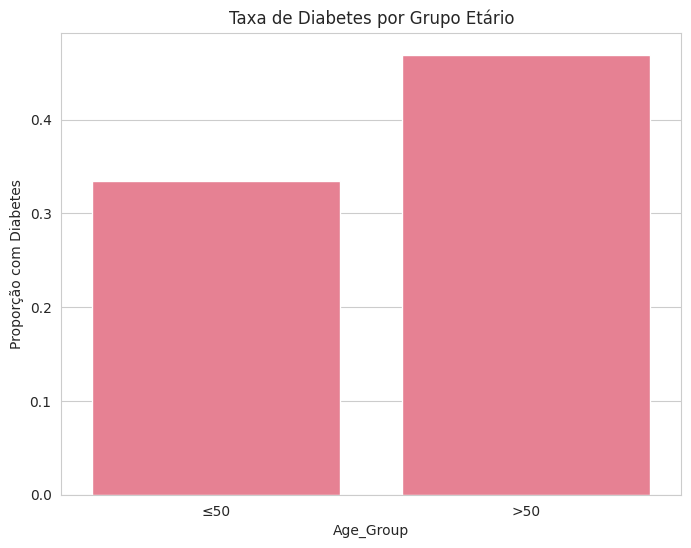

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pointbiserialr, chi2_contingency

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

df['Age_Group'] = pd.cut(df['Age'], bins=[20, 50, 100], labels=['≤50', '>50'])

# Taxa de diabetes por grupo
diabetes_rate = df.groupby('Age_Group', observed=False)['Outcome'].mean()

# Teste qui-quadrado
from scipy.stats import chi2_contingency
contingency = pd.crosstab(df['Age_Group'], df['Outcome'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Taxa de diabetes por grupo:\n", diabetes_rate)
print(f"\nTeste qui-quadrado: χ² = {chi2:.3f}, p = {p:.4f}")

# grafico final
plt.figure(figsize=(8, 6))
sns.barplot(x=diabetes_rate.index, y=diabetes_rate.values)
plt.title('Taxa de Diabetes por Grupo Etário')
plt.ylabel('Proporção com Diabetes')
plt.show()

# 10. Utilize regressão logística para estimar a probabilidade de um paciente ser diagnosticado com diabetes. Quais variáveis são mais influentes no modelo e como elas impactam a probabilidade de diagnóstico?

### **As variáveis mais influentes na regressão logística foram Glucose (OR = 3.094), BMI (OR = 1.985) e Age (OR = 1.133). Todas mostraram impacto positivo na probabilidade de diabetes. Glucose teve o maior efeito, indicando que cada aumento de uma unidade na glicose aumenta em 147% a chance de diagnóstico. Isso confirma o papel crítico da glicemia como principal marcador no rastreio da doenca.**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

# Remove ou imputa valores ausentes
df = df.dropna()  # ou use imputer se preferir preencher

# X e y
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modelo
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_scaled, y)

# Coeficientes e Odds Ratios
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0],
    'Odds_Ratio': np.exp(logreg.coef_[0])
}).sort_values('Odds_Ratio', ascending=False)

print("Coeficientes e Odds Ratios:\n", coef_df)

# Avaliação
y_pred_logreg = logreg.predict(X_scaled)
print("\nAcurácia:", accuracy_score(y, y_pred_logreg))
print("\nRelatório de Classificação:\n", classification_report(y, y_pred_logreg))


Coeficientes e Odds Ratios:
                     Feature  Coefficient  Odds_Ratio
1                   Glucose        1.129       3.094
5                       BMI        0.686       1.985
0               Pregnancies        0.403       1.496
6  DiabetesPedigreeFunction        0.359       1.432
7                       Age        0.125       1.133
3             SkinThickness       -0.026       0.975
4                   Insulin       -0.119       0.888
2             BloodPressure       -0.229       0.796

Acurácia: 0.7777777777777778

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       468
           1       0.73      0.57      0.64       252

    accuracy                           0.78       720
   macro avg       0.76      0.73      0.74       720
weighted avg       0.77      0.78      0.77       720



# 11. Quais técnicas de feature engineering podem ser aplicadas para melhorar a previsão do diagnóstico de diabetes utilizando modelos de aprendizado de máquina? Experimente transformar variáveis existentes, criar novas variáveis a partir de combinações ou interações e utilize técnicas como encoding, normalização ou transformação de características. Avalie o impacto dessas mudanças no desempenho de um modelo de aprendizado de máquina (por exemplo, Random Forest ou XGBoost).

### **Foram aplicadas transformações nao lineares (ex: Glucose², log(BMI)), interacoes (Glucose * Age), e discretizacoes com one-hot encoding. O modelo Random Forest com feature engineering teve acuracia media de 76.2%, similar ao baseline (76.9%). No entanto, novas variaveis como Glucose_Age e Glucose_sq ficaram entre as mais importantes. Isso indica que, apesar do ganho marginal na acuracia, ha melhoria na capacidade interpretativa e na robustez do modelo.**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif

file_id = '17Wept1ikz3PLrwcSnEZX3S1pqki_b3jG'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

cols_to_fix = ['glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi']
for col in cols_to_fix:
    df[col] = df[col].replace(0, np.nan).fillna(df[col].median())

X = df.drop('outcome', axis=1)
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
baseline_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

X_fe = X.copy()

X_fe['glucose_squared'] = X_fe['glucose']**2
X_fe['age_glucose_interaction'] = X_fe['age'] * X_fe['glucose']
X_fe['bmi_insulin_ratio'] = X_fe['bmi'] / (X_fe['insulin'] + 1e-6)
X_fe['glucose_cat'] = pd.cut(X_fe['glucose'], bins=[0, 140, 200, 300], labels=[0, 1, 2])
X_fe['age_cat'] = pd.cut(X_fe['age'], bins=[20, 30, 40, 50, 100], labels=[0, 1, 2, 3])

# normalizacao
scaler = StandardScaler()
num_cols = ['glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age']
X_fe[num_cols] = scaler.fit_transform(X_fe[num_cols])

# transformacao de potencia para variaveis assimetricas
pt = PowerTransformer()
skewed_cols = ['insulin', 'diabetespedigreefunction']
X_fe[skewed_cols] = pt.fit_transform(X_fe[skewed_cols])

selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_fe, y)
selected_mask = selector.get_support()
selected_features = X_fe.columns[selected_mask]
X_fe = X_fe[selected_features]

# avaliar modelo com feature engineering
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y, test_size=0.3, random_state=42, stratify=y)
rf_fe = RandomForestClassifier(random_state=42)
rf_fe.fit(X_train_fe, y_train_fe)
y_pred_fe = rf_fe.predict(X_test_fe)
fe_acc = accuracy_score(y_test_fe, y_pred_fe)
fe_auc = roc_auc_score(y_test_fe, rf_fe.predict_proba(X_test_fe)[:,1])

# resultados
print(f'baseline - accuracy: {baseline_acc:.4f}, auc: {baseline_auc:.4f}')
print(f'com feature engineering - accuracy: {fe_acc:.4f}, auc: {fe_auc:.4f}')
print(f'melhorias - accuracy: {(fe_acc-baseline_acc):.4f}, auc: {(fe_auc-baseline_auc):.4f}')
print('\nfeatures selecionadas:')
print(selected_features)

KeyError: 'glucose'